In [130]:
 !nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [131]:
import zipfile


!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-08-04 07:26:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M   287MB/s    in 0.6s    

2021-08-04 07:26:18 (287 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [132]:
import os
for dirpath,dirname,filename in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirname)} directories and {len(filename)} images in {dirpath} ")

there are 2 directories and 0 images in 10_food_classes_10_percent 
there are 10 directories and 0 images in 10_food_classes_10_percent/train 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/steak 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger 
there are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry 
there are

In [133]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"image shape: {img.shape}")
  return img

image shape: (512, 512, 3)


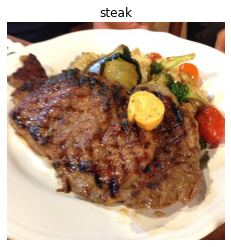

In [134]:
img=view_random_image(target_dir="10_food_classes_10_percent/test/",
                         target_class = "steak")

In [135]:
#data loder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# CAPS HYPERPARAMETER
IMG_SHAPE=(224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("training images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("training images")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")


training images
Found 750 images belonging to 10 classes.
training images
Found 2500 images belonging to 10 classes.


In [136]:
#calbacks(runs while models trains)

#create tensor board callback functionize

import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard log files {log_dir}")
  return tensorboard_callback
 

In [137]:
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

In [138]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
def create_model(model_url,num_classes =10 ):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=False,
                                         name="feature_extraction",
                                         input_shape = IMG_SHAPE+(3,))
  model = tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(num_classes, activation = 'softmax', name = "output_layer")
])
  ''' takes a tensorflow hub url and creates 
   Sequential model with it 
   args: model_url - feature extraction model from tfhub,
   model_classes= default 10 
   Returns uncompiled keras sequential model'''
  return model

 # create and testing resnet model

In [139]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [140]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction (KerasLay (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [141]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [142]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=10,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data= test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name='resnet50v2')])

saving tensorboard log files tensorflow_hub/resnet50v2/20210804-072622
Epoch 1/10
24/24 [==============================] - 49s 2s/step - loss: 1.8297 - accuracy: 0.3867 - val_loss: 1.1419 - val_accuracy: 0.6500
Epoch 2/10
24/24 [==============================] - 44s 2s/step - loss: 0.8317 - accuracy: 0.7667 - val_loss: 0.8342 - val_accuracy: 0.7332
Epoch 3/10
24/24 [==============================] - 45s 2s/step - loss: 0.5788 - accuracy: 0.8480 - val_loss: 0.7245 - val_accuracy: 0.7708
Epoch 4/10
24/24 [==============================] - 44s 2s/step - loss: 0.4453 - accuracy: 0.8947 - val_loss: 0.6967 - val_accuracy: 0.7744
Epoch 5/10
24/24 [==============================] - 44s 2s/step - loss: 0.3559 - accuracy: 0.9187 - val_loss: 0.6679 - val_accuracy: 0.7832
Epoch 6/10
24/24 [==============================] - 44s 2s/step - loss: 0.2910 - accuracy: 0.9440 - val_loss: 0.6398 - val_accuracy: 0.7896
Epoch 7/10
24/24 [==============================] - 44s 2s/step - loss: 0.2459 - accuracy

In [143]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history["loss"]))
  plt.plot(epochs, loss , label = 'training_loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy, label='training_accuracy')
  plt.plot(epochs,val_accuracy, label = 'val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend();

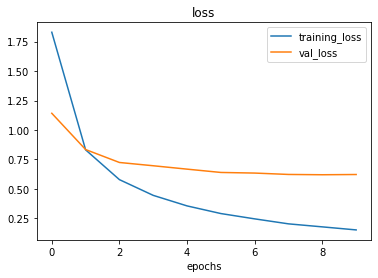

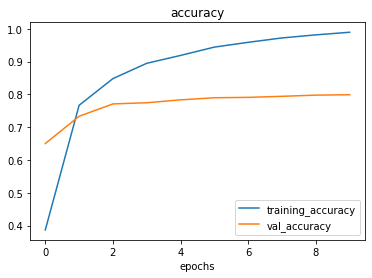

In [144]:
plot_loss_curves(resnet_history)

In [145]:
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes,
                                  )
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                            epochs=10,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data_10_percent,
                                            validation_steps=len(test_data_10_percent),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                   experiment_name='efficientnetb0')])

saving tensorboard log files tensorflow_hub/efficientnetb0/20210804-073350
Epoch 1/10
24/24 [==============================] - 41s 2s/step - loss: 1.8524 - accuracy: 0.4373 - val_loss: 1.3037 - val_accuracy: 0.7120
Epoch 2/10
24/24 [==============================] - 37s 2s/step - loss: 1.0765 - accuracy: 0.7773 - val_loss: 0.8685 - val_accuracy: 0.8156
Epoch 3/10
24/24 [==============================] - 36s 2s/step - loss: 0.7585 - accuracy: 0.8507 - val_loss: 0.7000 - val_accuracy: 0.8444
Epoch 4/10
24/24 [==============================] - 35s 2s/step - loss: 0.6121 - accuracy: 0.8747 - val_loss: 0.6149 - val_accuracy: 0.8540
Epoch 5/10
24/24 [==============================] - 36s 2s/step - loss: 0.5176 - accuracy: 0.8933 - val_loss: 0.5588 - val_accuracy: 0.8620
Epoch 6/10
24/24 [==============================] - 36s 2s/step - loss: 0.4485 - accuracy: 0.9133 - val_loss: 0.5224 - val_accuracy: 0.8640
Epoch 7/10
24/24 [==============================] - 36s 2s/step - loss: 0.3952 - accu

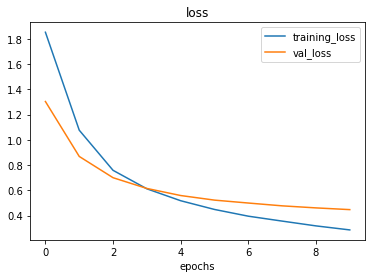

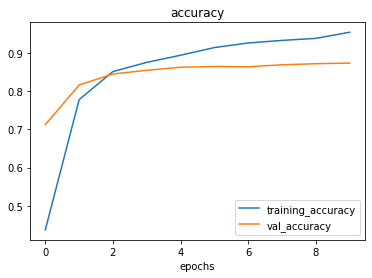

In [146]:
plot_loss_curves(efficientnet_history)

In [147]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction (KerasLay (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [148]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction (KerasLay (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [149]:
#upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "efficitivenetr vs resnet" \
 --description " computing two diffrent TF Hub feature extration model "\
 --one_shot


2021-08-04 07:39:56.379974: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

# transfer learning fine tuneing

In [150]:
!wget https://raw.githubusercontent.com/Balagopal-datascientist/cnn_tensorflow_food/master/helper_functions.py


--2021-08-04 08:16:04--  https://raw.githubusercontent.com/Balagopal-datascientist/cnn_tensorflow_food/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-04 08:16:04 (60.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [151]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [152]:
#tf.keras.applications
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2021-08-04 08:16:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.4’

10_food_classes_10_ 100%[===================>] 160.74M  96.5MB/s    in 1.7s    

2021-08-04 08:16:06 (96.5 MB/s) - ‘10_food_classes_10_percent.zip.4’ saved [168546183/168546183]



In [153]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [154]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [155]:
import tensorflow as tf 
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE,

)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [156]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [157]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [158]:
import matplotlib.pyplot as plt
for images,labels in train_data_10_percent.take(1):
 print(images,labels)

tf.Tensor(
[[[[1.01142860e+02 9.91428604e+01 7.81428604e+01]
   [8.62142868e+01 8.52142868e+01 6.52142868e+01]
   [6.47142868e+01 6.55000000e+01 5.03571434e+01]
   ...
   [1.09214264e+02 9.42142639e+01 6.12142639e+01]
   [1.08974487e+02 9.39744873e+01 6.09744835e+01]
   [1.08000000e+02 9.30000000e+01 6.00000000e+01]]

  [[1.03428574e+02 1.01428574e+02 8.04285736e+01]
   [8.85000000e+01 8.75000000e+01 6.75000000e+01]
   [6.70153046e+01 6.78010178e+01 5.26581650e+01]
   ...
   [1.10000000e+02 9.50000000e+01 6.20000000e+01]
   [1.09000000e+02 9.40000000e+01 6.10000000e+01]
   [1.09000000e+02 9.40000000e+01 6.10000000e+01]]

  [[1.04280617e+02 1.01637756e+02 7.88520432e+01]
   [9.07142868e+01 8.77857132e+01 6.86428604e+01]
   [6.89030609e+01 6.75459213e+01 5.27602043e+01]
   ...
   [1.10000000e+02 9.50000000e+01 6.20000000e+01]
   [1.10015312e+02 9.50153122e+01 6.20153084e+01]
   [1.11000000e+02 9.60000000e+01 6.30000000e+01]]

  ...

  [[3.64279175e+00 2.00000000e+00 2.14263916e-01]
   [4

functional api transfer learning functional api



In [159]:
#create base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable= False

inputs = tf.keras.layers.Input(shape=(224,224,3), name = "Input Layer")

#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)
#rescaeing not needed for efficient net

x = base_model(inputs)
print(f"shape after passing inuputs through base model: {x.shape}")

shape after passing inuputs through base model: (None, 7, 7, 1280)


In [160]:
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

In [161]:
print(f'shape after GlobalAveragePooling: {x.shape}')

shape after GlobalAveragePooling: (None, 1280)


In [162]:
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

In [163]:
model_0 = tf.keras.Model(inputs,outputs)

In [164]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_0 = model_0.fit(train_data_10_percent,
            steps_per_epoch = len(train_data_10_percent),
            epochs = 10,
            validation_data= test_data,
            validation_steps = len(test_data),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent")])

Saving TensorBoard log files to: transfer_learning/10_percent/20210804-081612
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 36s 1s/step - loss: 1.9377 - accuracy: 0.3907 - val_loss: 1.3559 - val_accuracy: 0.7020
Epoch 2/10
24/24 [==============================] - 29s 1s/step - loss: 1.1629 - accuracy: 0.7440 - val_loss: 0.9192 - val_accuracy: 0.8004
Epoch 3/10
24/24 [==============================] - 28s 1s/step - loss: 0.8470 - accuracy: 0.8067 - val_loss: 0.7507 - val_accuracy: 0.8220
Epoch 4/10
24/24 [==============================] - 29s 1s/step - loss: 0.7058 - accuracy: 0.8360 - val_loss: 0.6593 - val_accuracy: 0.8368
Epoch 5/10
24/24 [==============================] - 28s 1s/step - loss: 0.5990 - accuracy: 0.8547 - val_loss: 0.6060 - val_accuracy: 0.8456
Epoch 6/10
24/24 [==============================] - 29s 1s/step - loss: 0.5197 - accuracy: 0.8840 - val_loss: 0.5681 - val_accuracy: 0.8456
Epoch 7/10
24/24 [==============================] - 29s 1s/step - loss: 0.4737 - accuracy: 0.8987 - val_loss: 0.5407 - val_accuracy: 0.8504
Epoch 8/10
24/24 [=============

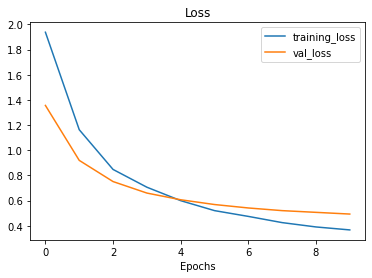

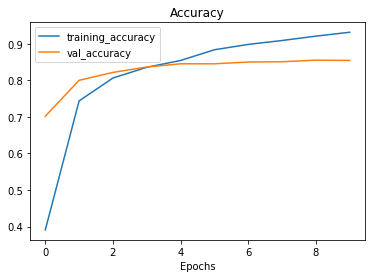

In [165]:
plot_loss_curves(history_0)

In [166]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number, layer.name )

0 input_14
1 rescaling_22
2 normalization_13
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3

In [167]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_22 (Rescaling)        (None, None, None, 3 0           input_14[0][0]                   
__________________________________________________________________________________________________
normalization_13 (Normalization (None, None, None, 3 7           rescaling_22[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_13[0][0]           
_____________________________________________________________________________________

In [168]:
model_0.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [169]:
input_shape = (1,4,4,3)
tf.random.set_seed=42
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor {input_tensor}')

Random input tensor [[[[-1.0268447   0.29173642  0.89103067]
   [-0.39298007 -0.55237883  0.24623953]
   [-1.9122769  -1.8978652   2.1077056 ]
   [-1.0079513  -0.79416466 -1.9248228 ]]

  [[-1.0527248   0.22295024 -1.1188521 ]
   [-0.03547163  0.28282407  0.59008294]
   [ 0.5377123  -0.765559   -0.71518433]
   [ 2.563937    1.4841549  -0.76392597]]

  [[-0.8427759   0.08415125 -1.1617941 ]
   [ 1.7866554  -0.5123669   0.95975566]
   [-1.0531963  -0.92610323  0.35545373]
   [-0.53585434 -1.4732504   0.8762467 ]]

  [[-0.592895   -0.7344572  -0.69382644]
   [-1.045257   -1.5110797  -0.19115588]
   [ 0.98122525  1.3373657  -0.7336318 ]
   [-0.49080524  0.5691572  -0.07351904]]]]


In [170]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2d global average pooled random tensor \n{global_average_pooled_tensor}")

2d global average pooled random tensor 
[[-0.25746897 -0.30593032 -0.08438735]]


In [171]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2d global max pooled random tensor \n{global_max_pooled_tensor}")

2d global max pooled random tensor 
[[2.563937  1.4841549 2.1077056]]


In [172]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2021-08-04 08:21:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  97.8MB/s    in 1.3s    

2021-08-04 08:21:08 (97.8 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [173]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [174]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size =IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size =IMG_SIZE,
                                                                batch_size = BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [175]:
#data augmentation directly added into our model


In [176]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 
data_augmentation = keras.Sequential([
                   preprocessing.RandomFlip("horizontal"),
                   preprocessing.RandomRotation(0.2),
                   preprocessing.RandomZoom(0.2),
                   preprocessing.RandomHeight(0.2),
                   preprocessing.RandomWidth(0.2),
                   #preprocessing.Rescaling(1/255.)

], name = "data_augmentation")

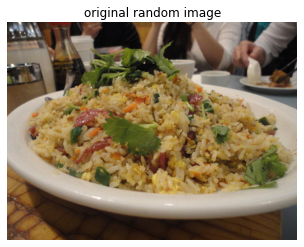

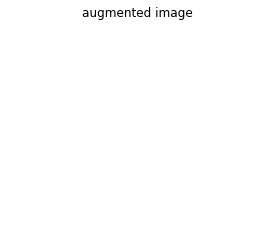

In [177]:
#visualize data augmentation layer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir =  "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.title("original random image")
plt.axis(False)
plt.imshow(img) 

#augmented image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.title("augmented image")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_img))

In [178]:
#model_! feature extaction transfer learning
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
  #input layer
inputs = layers.Input(shape = input_shape, name = "input_layer")

x = data_augmentation(inputs)
x = base_model(x, training = False)#whole model 
x = layers.GlobalAveragePooling2D(name = "globalaveragepooling")(x) # layer
outputs = layers.Dense(10 , activation = "softmax", name = "output")(x)

model_1 = keras.Model(inputs,outputs)


In [179]:
# compile 
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics =  ['accuracy'])
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs= 5,
                                steps_per_epoch= len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data) ),
                                callbacks=[create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                       experiment_name= "1_pecent_data")] )

Saving TensorBoard log files to: transfer_learning/1_pecent_data/20210804-082113
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 13s 4s/step - loss: 2.4463 - accuracy: 0.0714 - val_loss: 2.2746 - val_accuracy: 0.1234
Epoch 2/5
3/3 [==============================] - 6s 3s/step - loss: 2.2005 - accuracy: 0.1571 - val_loss: 2.1530 - val_accuracy: 0.1974
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 2.0019 - accuracy: 0.2571 - val_loss: 2.0487 - val_accuracy: 0.3125
Epoch 4/5
3/3 [==============================] - 6s 3s/step - loss: 1.8466 - accuracy: 0.5143 - val_loss: 1.9477 - val_accuracy: 0.3898
Epoch 5/5
3/3 [==============================] - 6s 3s/step - loss: 1.6921 - accuracy: 0.6429 - val_loss: 1.8473 - val_accuracy: 0.4737


In [180]:
model_1.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
globalaveragepooling (Global (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [181]:
 result_1_percent_data_aug = model_1.evaluate(test_data)
 result_1_percent_data_aug

79/79 [==============================] - 22s 277ms/step - loss: 1.8604 - accuracy: 0.4668


[1.8604152202606201, 0.4668000042438507]

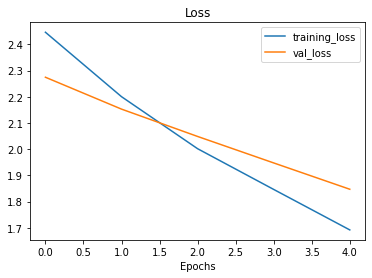

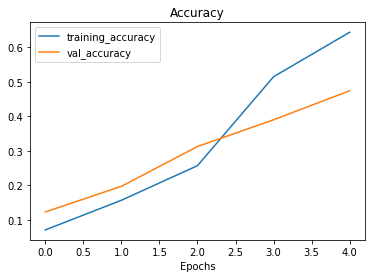

In [182]:
plot_loss_curves(history_1_percent)

In [183]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2021-08-04 08:22:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.5’

10_food_classes_10_ 100%[===================>] 160.74M  90.1MB/s    in 1.8s    

2021-08-04 08:22:15 (90.1 MB/s) - ‘10_food_classes_10_percent.zip.5’ saved [168546183/168546183]



In [184]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [185]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [186]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [187]:
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomZoom(0.2),
                                #preprocessing.Rescaling(1/255.)
                            
], name =  "data_augmentation")
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs)

x = base_model(x, training = False)

x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation = "softmax", name = "ouput")(x)
model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(loss= "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics = ['accuracy'])


In [188]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#model checkpoint 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = 'epoch',
                                                         verbose = 1)

In [189]:
initial_epochs = 5

history_10_percent = model_2.fit(train_data_10_percent,
                                 epochs = initial_epochs,
                                 validation_data = test_data,
                                 validation_steps = len(test_data),
                                 callbacks = [create_tensorboard_callback(dir_name = "treansfer_learning",experiment_name = "10_percent data"),
                                              checkpoint_callback])

Saving TensorBoard log files to: treansfer_learning/10_percent data/20210804-082220
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 36s 1s/step - loss: 1.3419 - accuracy: 0.5653 - val_loss: 0.6273 - val_accuracy: 0.7860

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 29s 1s/step - loss: 0.6254 - accuracy: 0.7960 - val_loss: 0.5420 - val_accuracy: 0.8200

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 30s 1s/step - loss: 0.4556 - accuracy: 0.8453 - val_loss: 0.5415 - val_accuracy: 0.8232

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 30s 1s/step - loss: 0.3451 - accuracy: 0.8853 - val_loss: 0.5334 - val_accuracy: 0.8312

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 30s 1s/step - loss: 0.2934 - accuracy: 0.8973 - val_loss: 0.5259 - 

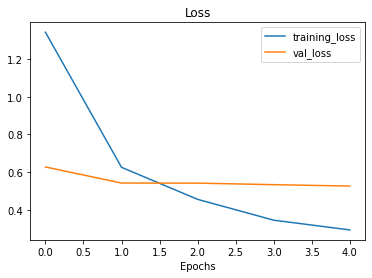

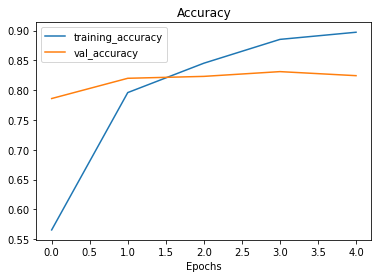

In [190]:
plot_loss_curves(history_10_percent)

In [191]:
#loading weights
model_2.load_weights(checkpoint_path)

In [192]:
model_2.evaluate(test_data)

79/79 [==============================] - 22s 281ms/step - loss: 0.5259 - accuracy: 0.8244


[0.5258905291557312, 0.824400007724762]

fine tuning data model 3

In [193]:
model_2.layers

In [194]:
base_model.trainable = True
#freeze all the layers except last 10 
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [195]:
model_2.compile(loss= "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ["accuracy"])

In [196]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name, layer.trainable)

0 input_16 False
1 rescaling_24 False
2 normalization_15 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [197]:
fine_tune_epochs = initial_epochs + 5


In [198]:
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs= fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = len(test_data),
                                               initial_epoch = history_10_percent.epoch[-1],
                                               callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                       experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210804-082520
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 37s 1s/step - loss: 0.2098 - accuracy: 0.9387 - val_loss: 0.5117 - val_accuracy: 0.8444
Epoch 6/10
24/24 [==============================] - 30s 1s/step - loss: 0.1781 - accuracy: 0.9453 - val_loss: 0.5120 - val_accuracy: 0.8420
Epoch 7/10
24/24 [==============================] - 31s 1s/step - loss: 0.1463 - accuracy: 0.9547 - val_loss: 0.5128 - val_accuracy: 0.8540
Epoch 8/10
24/24 [==============================] - 31s 1s/step - loss: 0.1367 - accuracy: 0.9587 - val_loss: 0.5008 - val_accuracy: 0.8556
Epoch 9/10
24/24 [==============================] - 30s 1s/step - loss: 0.1370 - accuracy: 0.9653 - val_loss: 0.5292 - val_accuracy: 0.8528
Epoch 10/10
24/24 [==============================] - 29s 1s/step - loss: 0.1091 - accuracy: 0.9653 - val_loss: 0.5221 - val_accuracy: 0.8584


In [199]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.5653333067893982, 0.7960000038146973, 0.8453333377838135, 0.8853333592414856, 0.8973333239555359, 0.9386666417121887, 0.9453333616256714, 0.9546666741371155, 0.9586666822433472, 0.9653333425521851, 0.9653333425521851]


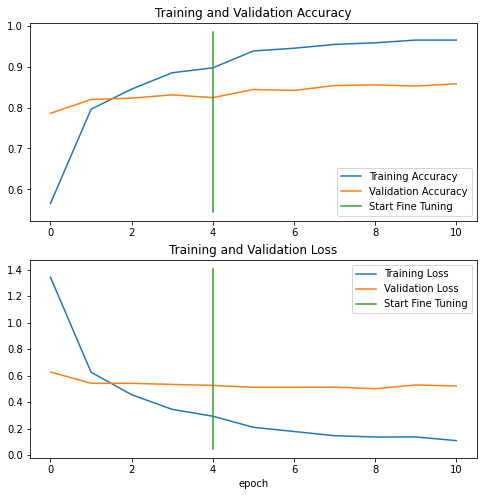

In [200]:
compare_historys(original_history=history_10_percent, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

#model 4 all data

In [201]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2021-08-04 08:28:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.198.128, 64.233.191.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.198.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   137MB/s    in 4.2s    

2021-08-04 08:28:32 (119 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [202]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [203]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [204]:
model_2.evaluate(test_data)

79/79 [==============================] - 23s 286ms/step - loss: 0.5221 - accuracy: 0.8584


[0.5220553278923035, 0.8583999872207642]

In [205]:
model_2.load_weights(checkpoint_path)

In [206]:
model_2.evaluate(test_data)

79/79 [==============================] - 22s 283ms/step - loss: 0.5259 - accuracy: 0.8244


[0.5258904099464417, 0.824400007724762]

In [207]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

In [208]:
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           initial_epoch = history_10_percent.epoch[-1],
                                           validation_data = test_data,
                                           validation_steps = len(test_data),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210804-084838
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 107s 434ms/step - loss: 0.6798 - accuracy: 0.7889 - val_loss: 0.3821 - val_accuracy: 0.8736
Epoch 6/10
235/235 [==============================] - 101s 428ms/step - loss: 0.5444 - accuracy: 0.8268 - val_loss: 0.3667 - val_accuracy: 0.8868
Epoch 7/10
235/235 [==============================] - 100s 423ms/step - loss: 0.4936 - accuracy: 0.8425 - val_loss: 0.3416 - val_accuracy: 0.8908
Epoch 8/10
235/235 [==============================] - 102s 433ms/step - loss: 0.4408 - accuracy: 0.8571 - val_loss: 0.3454 - val_accuracy: 0.8892
Epoch 9/10
235/235 [==============================] - 102s 435ms/step - loss: 0.3982 - accuracy: 0.8720 - val_loss: 0.3236 - val_accuracy: 0.9008
Epoch 10/10
235/235 [==============================] - 100s 427ms/step - loss: 0.3730 - accuracy: 0.8788 - val_loss: 0.3256 - val_accuracy: 0.8984


In [209]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 23s 286ms/step - loss: 0.3256 - accuracy: 0.8984


[0.3256221413612366, 0.8984000086784363]

5
11
[0.5653333067893982, 0.7960000038146973, 0.8453333377838135, 0.8853333592414856, 0.8973333239555359, 0.7889333367347717, 0.8267999887466431, 0.8425333499908447, 0.8570666909217834, 0.871999979019165, 0.8787999749183655]


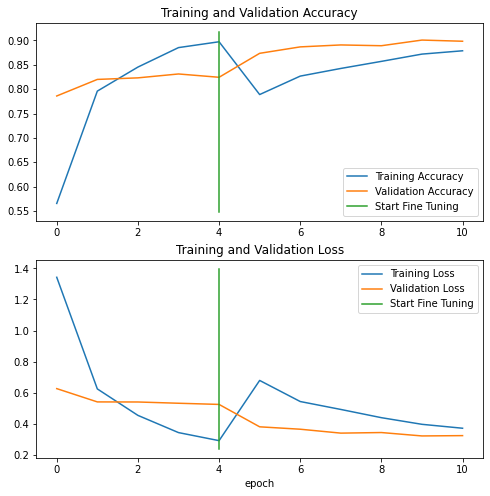

In [211]:
compare_historys(original_history=history_10_percent,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [213]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot

2021-08-04 09:05:07.546914: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/iwPuNppGQS6pnUd2S2HyxA/

[2021-08-04T09:05:08] Started scanning logdir.
[2021-08-04T09:05:19] Total uploaded: 318 scalars, 0 tensors, 11 binary objects (9.0 MB)
[2021-08-04T09:05:19] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/iwPuNppGQS6pnUd2S2HyxA/


In [214]:
!tensorboard dev list

2021-08-04 09:05:23.887370: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/iwPuNppGQS6pnUd2S2HyxA/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   iwPuNppGQS6pnUd2S2HyxA
	Created              2021-08-04 09:05:08 (25 seconds ago)
	Updated              2021-08-04 09:05:19 (14 seconds ago)
	Runs                 19
	Tags                 5
	Scalars              318
	Tensor bytes         0
	Binary object bytes  9396930
https://tensorboard.dev/experiment/epzoL3oRTkCxWRztr0TPJA/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   epzoL3oRTkCxWRztr0TPJA
	Created              2021-08-04 09:02:13 (3 minutes ago)

In [215]:
!tensorboard dev delete --experiment_id mZZLbB9mT1Gn3YU6F3JEkQ

2021-08-04 09:06:09.053488: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Deleted experiment mZZLbB9mT1Gn3YU6F3JEkQ.


In [ ]:
# scaleing up 
